# 06 - Doc2Vec
This notebook explores the governance data set using Doc2Vec. Doc2vec might be a good fit for our project as dimensionality reducer.

This code is largely based on [Document-Clustering-Doc2vec](https://github.com/aniketbote/Document-Clustering-Doc2vec/blob/master/Clustering/Clustering_code_Doc2Vec/clustering_Documents_Doc2Vec.py) by [Aniket Bote](https://github.com/aniketbote). We did remove the fixed seed for the randomizer.

Further reading [A gentle introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) by [Gidi Shperber](https://medium.com/@gidishperber) or [Doc2Vec — Computing Similarity between Documents](https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd) by [Abdul Hafeez Fahad](https://medium.com/@a.h.fahad18).


** Kaartje met clusters over gemeenten, dus voor zowel LSA and Doc2Vec een kaartje genereren welke gemeenten in welk cluster zitten
XXX **

---
## Dependencies and Imports
This section deals with fulfilling depenencies and installing the right packages for use in the code below.

Something to keep in mind is that a lot of sample code out there uses Gensum version 3, where we use the current-as-of-this-writing Gensim version 4. The API has changed quite a bit between versions 3 and 4 and sample code may need to be refactored to use the new API before it works. Most changes are in the naming and will cause run-time errors, so finding problems is easy.

In [1]:
!pip install gensim fastparquet scikit-learn matplotlib wordcloud

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'
GZIP='gzip'

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import __version__ as gensim__version__
print(f"gensim=={gensim__version__}")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")
from sklearn.feature_extraction.text import TfidfVectorizer


python==3.11.4
pandas==2.0.2
gensim==4.3.1
scikit-learn==1.2.2
matplotlib==3.7.1
wordcloud==1.9.2
scikit-learn==1.2.2


---
## Load DV Data Set
This loads the DV data set. We first load as a Panda, because we have the code. Then we make the resultant `corpus` into the list of tagged documents that Gensim is designed to work with.

We also load the municipalities evaluation set. We will use that after clustering with the intention to be able to relate clusters to municipalities.

Finally, we load the document properties. These will help identify document classification issues by looking at the titles.

Spoiler alert, one of the results of outlier detection on our clustering revealed that some documents were misclassified.
The documents below are tagged as duurzaamheidvisie, but are really budget plans.

We found these as visible outliers in on of the clusters. Here we retrieve them by document title. Based on the earlier clustering run we now know what to look for.

In [3]:
DOCUMENT_ID = 'DocID'
DOCUMENT_TITLE = 'Titel'
JAAR = 'Jaar'

documents = pd.read_csv("../data/Governance/Duurzaamheidsvisies.csv", index_col=DOCUMENT_ID)
documents[JAAR] = documents[JAAR].astype(STRING).str.slice(0, 4)

documents[documents[DOCUMENT_TITLE].str.contains("egrot")]


,Titel,Jaar
DocID,,
GM0331DV01,Programmabegroting 2016,2015
GM0852DV01,Programmabegroting 2016,2016
GM0981DV01,Programma begroting 2016,2015


In [4]:
CACHE_DIR = '../cache/Governance'

# The Parquet files, gzipped.
ALL_PARQUET_GZ = CACHE_DIR + '/ALL_documents.parquet.gz'
DV_PARQUET_GZ  = CACHE_DIR + '/DV_documents.parquet.gz'

DV_corpus  = pd.read_parquet(DV_PARQUET_GZ)
ALL_corpus = pd.read_parquet(ALL_PARQUET_GZ)

# columns ofthe data set
DOCUMENT_BODY = 'body'
DOCUMENT_TITLE = 'Titel'
DOCUMENT_JAAR = 'Jaar'
MUNICIPALITY_CODE='GM_CODE'

corpus = DV_corpus
corpus.head()

,body,GM_CODE,Titel,Jaar
index,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010


In [5]:
def make_into_tagged_documents(series):
    return [TaggedDocument(doc.split(' '), [i]) for i, doc in series.items()]

In [6]:
all_content = make_into_tagged_documents(corpus[DOCUMENT_BODY])
for i in range(5):
    print(f"{all_content[i].tags[0]}: {all_content[i].words[:5]}".replace("]", " ..."))

GM0003DV02: ['duurzaamheidsbeleid', 'Appingedam', 'duurzaamheidsbeleid', 'Appingedam', 'Inhoud' ...
GM0005DV01: ['colofon', 'gemeente', 'bedum', 'bezoekadres', 'Schoolstraat' ...
GM0007DV01: ['Milieubeleidsplan', 'vaststellen', 'gemeenteraad', 'bellingweden', 'maart' ...
GM0009DV01: ['inhoud', 'duurzaamheidsvisie', 'februari', 'inhoud', 'inhoud' ...
GM0034DV01: ['verseonnr', 'dagmail', 'december', 'raad', 'gemeente' ...


In [7]:
municipalities = pd.read_parquet("../data/CBS/Evaluation_data.parquet")
municipalities


,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
index,,,,,,,,,,,,,,,,,,,
0,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
2,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
3,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
4,GM0010,Delfzijl,Groningen,Klein,Arm,weinig stedelijk,Lokaal,Veel,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,GM1940,De Fryske Marren,Fryslân,Middelgroot,Modaal,weinig stedelijk,None,Gemiddeld,Veel,Veel,Gemiddeld,Gemiddeld,Gemiddeld,Middel,Laag,Middel,Middel,iets minder,meer
386,GM1942,Gooise Meren,Noord-Holland,Middelgroot,Rijk,sterk stedelijk,VVD,Geen,Beperkt,Geen,Beperkt,Geen,Beperkt,Hoog,Middel,Middel,Middel,veel lager,iets minder
387,GM1945,Berg en Dal,Gelderland,Middelgroot,Modaal,weinig stedelijk,Lokaal,Geen,Beperkt,Geen,Gemiddeld,Geen,Gemiddeld,Middel,Middel,Middel,Middel,iets minder,iets minder


---
## Train the Doc2Vec Model
With the data cleanly loaded, we can train the model. Since we are very much exploring and since training is relatively fast, we don't save the model. We simply retrain it every time.

One question that came up is whether we migth be overfitting. We have fewer than 300 documents, yet we train towards vectors of 300 dimensions. This is not a problem per se, as the training does not happen on individual documents, but rather on 5-grams of these documents. There are rather more than 300 5-grams.

Another topic we disucssed was whether 

In [8]:
d2v_model = Doc2Vec(all_content, vector_size=300, min_count=5, dm=0, alpha=0.0025, min_alpha=0.0001)
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)


---
## Elbow and Cluster with K-Means
We use the learned vectors to cluster the DV data set again using K-Means clustering. First we run K-Means clustering for different cluster sizes to make the elbow plot. Then we run K-Means to find the optimal number of clusters that we chose based on the elbow plot. We chose 5.


In [9]:
nc = range(1, 100)
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500) for i in nc]               
score  = [kmeans[i].fit(d2v_model.dv.vectors).inertia_ for i in range(len(kmeans))]

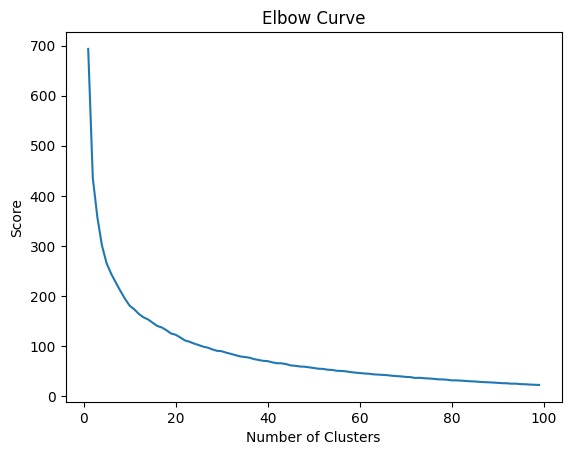

In [10]:
# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [11]:
K_value = 5
kmeans_model = KMeans(n_clusters=K_value, n_init='auto') 
kmeans_model.fit(d2v_model.dv.vectors)

# XXX Where should I get clusters, from the model or as a result from predict()?
__clusters = kmeans_model.predict(d2v_model.dv.vectors)
labels = kmeans_model.labels_.tolist()


# // XXX add as dataframe

## Silhouette score
The silhouette score is a metric provided by scikit-learn that measures the quality of clustering results based on the average distance between samples within clusters and the average distance between samples in different clusters. It takes into account both the cohesion (how close samples are to each other within the same cluster) and the separation (how far samples are from samples in other clusters). The range is from -1 to 1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [12]:
# Nog even checken bij Corné en Kees Jan of ze mijn gedachte kunnen volgen dat ik hier dv2 gebruik.
silhouette_avg = silhouette_score(d2v_model.dv.vectors, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.24789011


---
## PCA Analysis and Plotting
We use Principal Component Analysis (PCA) to flatten the 300-dimension document vectors onto a 2D shape for plotting. The banding in the graph below is an artefact of PCA, as the resulting components are not correlated.

In [13]:
# XXX Investigate precisely fit()/predict()/fit_predict().
# Which ones change the internal model state and have side effects?

__l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)

# // XXX add to data frame

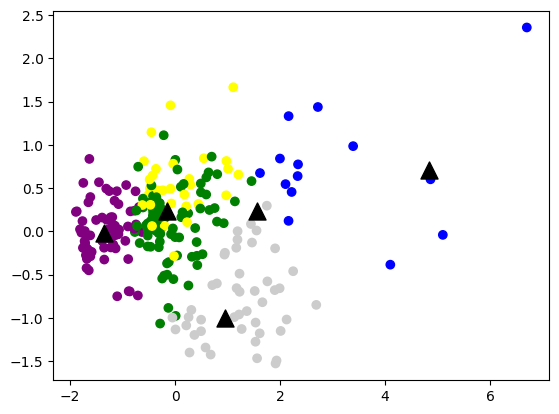

In [14]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#cccccc"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

# XXX print the document weigths for each document, sow we can identify them on the plot

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')

plt.show()


---
## Link to Municipality Data
This section three-way merges the clusters we found with the municipality data and document details for evaluation. Municipalities are indexed by their GM-code. Documents by their base file name.

In [15]:
CLUSTER='cluster'
MUNICIPALITY_ID='GM_Code'

kmeans_clusters = pd.DataFrame(index=corpus.index)
kmeans_clusters['DocID'] = corpus.index
kmeans_clusters[CLUSTER] = labels
kmeans_clusters[MUNICIPALITY_ID] = corpus.index.str.slice(0, 6)

kmeans_clusters.head()

,DocID,cluster,GM_Code
index,,,
GM0003DV02,GM0003DV02,1,GM0003
GM0005DV01,GM0005DV01,4,GM0005
GM0007DV01,GM0007DV01,4,GM0007
GM0009DV01,GM0009DV01,1,GM0009
GM0034DV01,GM0034DV01,1,GM0034


In [16]:
kmeans_clusters_with_municipalities = kmeans_clusters.merge(municipalities, how="left", on=MUNICIPALITY_ID).set_index('DocID')

# the merge adds suffixes to ensure unique column names, so we strip those off
# again since we have no name clashes.
kmeans_clusters_with_municipalities.columns=kmeans_clusters_with_municipalities.columns.str.rstrip('_x') 
kmeans_clusters_with_municipalities.head()


,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
DocID,,,,,,,,,,,,,,,,,,,,
GM0003DV02,1,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
GM0005DV01,4,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
GM0007DV01,4,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
GM0009DV01,1,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
GM0034DV01,1,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,Veel,Veel,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager


In [17]:
kmeans_clusters_with_everything = kmeans_clusters_with_municipalities.join(documents)
kmeans_clusters_with_everything.head()



,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,...,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat,Titel,Jaar
DocID,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,1,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,...,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,4,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,...,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder,Milieubeleidsplan 2009-2012,2009
GM0007DV01,4,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,...,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,1,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,...,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,1,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,...,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager,Plan van aanpak duurzaamheidsagenda,2010


In [18]:
kmeans_clusters_with_everything.to_parquet("../data/Governance/Doc2Vec_clusters.parquet")
kmeans_clusters_with_everything.loc[kmeans_clusters_with_everything[CLUSTER]==4, ['GM_Code', 'Gemeente', 'Titel', 'Jaar']]


,GM_Code,Gemeente,Titel,Jaar
DocID,,,,
GM0005DV01,GM0005,Bedum,Milieubeleidsplan 2009-2012,2009
GM0007DV01,GM0007,Bellingwedde,Milieubeleidsprogramma 2007-2015,2007
GM0063DV01,GM0063,het Bildt,Milieubeleidsplan,2015
GM0141DV01,GM0141,Almelo,duurzaamheidsbeleidsplan 2013 - 2016,2013
GM0230DV01,GM0230,Elburg,Milieubeleidsplan Gemeente Elburg 2010-2013,2013
GM0274DV01,GM0274,Renkum,Milieuvisie 2013-2016,2013
GM0281DV01,GM0281,Tiel,Milieuvisie 2010-2020 - Gemeente Tiel,2010
GM0293DV01,GM0293,Westervoort,Milieuprogramma Westervoort,2016
GM0294DV01,GM0294,Winterswijk,Duurzaam Winterswijk,2008


---
## Word Clouds and Word Lists
With the clustered established, we can now make word clouds of each of them. Before we can work with word clouds, we have to merge the K-Means clusters with the original corpus. The word clouds need the text.

In [19]:
corpus_with_cluster = corpus.join(kmeans_clusters)
corpus_with_cluster.head()


,body,GM_CODE,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,1,GM0003
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009,GM0005DV01,4,GM0005
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007,GM0007DV01,4,GM0007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,1,GM0009
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,1,GM0034


In [20]:
documents_with_cluster = corpus_with_cluster.iloc[:, 2:]
documents_with_cluster

,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,
GM0003DV02,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,1,GM0003
GM0005DV01,Milieubeleidsplan 2009-2012,2009,GM0005DV01,4,GM0005
GM0007DV01,Milieubeleidsprogramma 2007-2015,2007,GM0007DV01,4,GM0007
GM0009DV01,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,1,GM0009
GM0034DV01,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,1,GM0034
...,...,...,...,...,...
GM1945DV01,Duurzaamheidsprogramma - Gemeente Berg en Dal,2013,GM1945DV01,0,GM1945
GM1955DV01,Milieuprogramma 2014,2014,GM1955DV01,4,GM1955
GM1955DV02,Zonne-energie in het buitengebied,0,GM1955DV02,3,GM1955


In [21]:
MIN_DF=15
MAX_DF=0.95
SUBLINEAR_TF=True

def document_bodies_in_cluster(corpus, cluster):
    return corpus[corpus[CLUSTER]==cluster][DOCUMENT_BODY]

def nlargest_of(corpus, cluster, n):
    docs = document_bodies_in_cluster(corpus, cluster)

    if len(docs) < MIN_DF:
        print(f"only {len(docs)} documents in cluster {cluster}, setting `min_df` and `max_df` system defaults")
        vectorizer = TfidfVectorizer(sublinear_tf=SUBLINEAR_TF)
    else:
        vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

    counts = vectorizer.fit_transform(docs)
    totals = counts.sum(0)
    return pd.DataFrame(totals.T, index=vectorizer.get_feature_names_out())[0].nlargest(n)

def print_cluster(corpus, cluster):
    print(nlargest_of(corpus, cluster, 20))

def cloud_of_cluster(corpus, cluster):
    cloud = WordCloud(background_color="white", max_words=20).generate_from_frequencies(nlargest_of(corpus, cluster, 50))
    plt.axis('off')
    plt.imshow(cloud);


duurzaamheid            1.767003
eur                     1.696141
bouwen                  1.666023
regionaal               1.610965
uitstoot                1.600957
ver                     1.593269
zien                    1.587697
klimaatbeleid           1.572651
opstellen               1.557435
activiteit              1.539950
resultaat               1.532900
uur                     1.528101
verlichting             1.517979
uitvoeringsprogramma    1.505707
samen                   1.492175
inwoner                 1.486854
nieuwbouw               1.474759
mobiliteit              1.469481
communicatie            1.442517
klimaat                 1.442133
Name: 0, dtype: float64


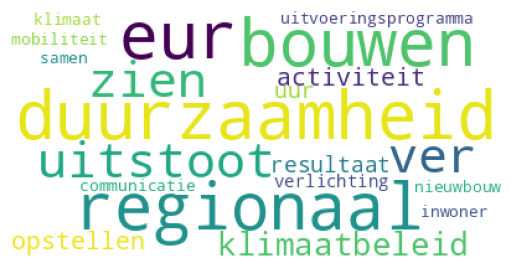

In [22]:
print_cluster(corpus_with_cluster, 0)
cloud_of_cluster(corpus_with_cluster, 0)


ambitie             3.165183
gebouw              3.007030
beleid              2.986659
milieu              2.855446
maatregel           2.851788
afval               2.831400
water               2.809270
maatschappelijk     2.762632
sociaal             2.761136
thema               2.747455
energiebesparing    2.719572
doelstelling        2.707864
wij                 2.704616
partij              2.644470
opstellen           2.624134
kans                2.617356
vanuit              2.590551
kader               2.588851
mens                2.587875
activiteit          2.561329
Name: 0, dtype: float64


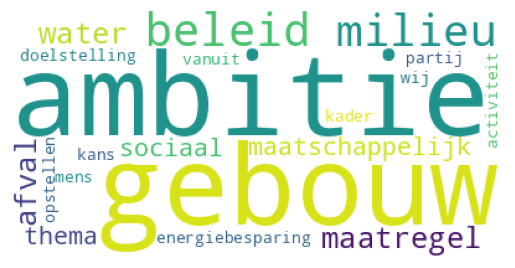

In [23]:
print_cluster(corpus_with_cluster, 1)
cloud_of_cluster(corpus_with_cluster, 1)


only 14 documents in cluster 2, setting `min_df` and `max_df` system defaults
gemeente        0.418263
duurzaam        0.400130
energie         0.376255
maken           0.348890
groen           0.341481
goed            0.340064
zullen          0.336752
ander           0.334654
gaan            0.330892
gebied          0.329652
jaar            0.328221
per             0.327761
bedrijf         0.327374
komen           0.326348
duurzaamheid    0.325999
project         0.323705
mogelijk        0.322045
groot           0.320408
moeten          0.318748
nieuw           0.316503
Name: 0, dtype: float64
only 14 documents in cluster 2, setting `min_df` and `max_df` system defaults


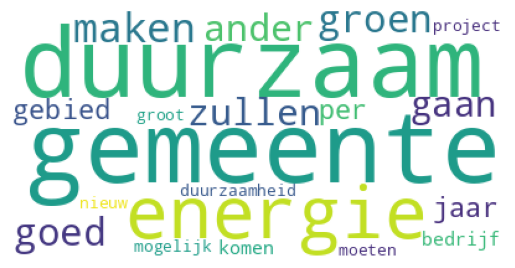

In [24]:
print_cluster(corpus_with_cluster, 2)
cloud_of_cluster(corpus_with_cluster, 2)


duurzaamheid        4.264204
project             4.153275
gemeentelijk        3.785328
organisatie         3.469874
lokaal              3.412973
goed                3.334228
eur                 3.259385
ontwikkeling        3.218226
moeten              3.217702
energiebesparing    3.182794
gebouw              3.042255
inwoner             2.985912
stimuleren          2.969927
uitvoeren           2.963297
thema               2.944788
wij                 2.931489
maatregel           2.929447
rol                 2.921619
belangrijk          2.920029
ambitie             2.912313
Name: 0, dtype: float64


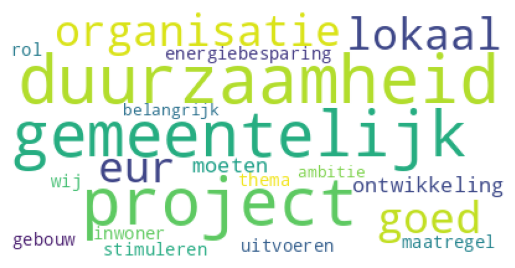

In [25]:
print_cluster(corpus_with_cluster, 3)
cloud_of_cluster(corpus_with_cluster, 3)


afval                   2.085803
duurzaamheid            1.965889
luchtkwaliteit          1.954013
stof                    1.821217
bodem                   1.791616
natuur                  1.784036
geluid                  1.780006
gebouw                  1.768877
wel                     1.755109
inwoner                 1.711794
besluit                 1.707571
milieubeleidsplan       1.694948
milieubeleid            1.692357
bouwen                  1.685241
vervoer                 1.599844
programma               1.597191
bijlage                 1.579714
regio                   1.577030
uitvoeringsprogramma    1.571531
klimaat                 1.567551
Name: 0, dtype: float64


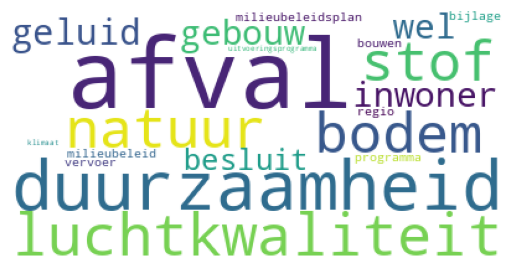

In [26]:
print_cluster(corpus_with_cluster, 4)
cloud_of_cluster(corpus_with_cluster, 4)


In [27]:
corpus_with_cluster[corpus_with_cluster[CLUSTER] == 3]

,body,GM_CODE,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,,,
GM0047DV01,duurzaamheidsagenda slim werk slim bespaar voo...,GM0047,duurzaamheidsvisie vastgesteld,2016,GM0047DV01,3,GM0047
GM0050DV01,kwaliteit leefbaarheid realiseer samen duurzaa...,GM0050,Duurzaamheidsprogramma,0,GM0050DV01,3,GM0050
GM0060DV01,programma duurzaamheid waddeneilanden inleidin...,GM0060,Programma Duurzaamheid Waddeneilanden 2015,2014,GM0060DV01,3,GM0060
GM0148DV01,meerjarenprogramma klimaat duurzaamheid weg du...,GM0148,Meerjarenprogramma Duurzaamheid 2014-2015,2013,GM0148DV01,3,GM0148
GM0160DV01,duurzaam Hardenberg eeicuat laag soa ouurzoam ...,GM0160,Duurzaam Hardenberg Een bewuste keuze?,0,GM0160DV01,3,GM0160
...,...,...,...,...,...,...,...
GM1904DV01,stichtse vecht energiek samen sterk duurzaamhe...,GM1904,Duurzaamheidsvisie 2014-2020,2013,GM1904DV01,3,GM1904
GM1926DV01,pijnacker Nootdorp weg energieneutraal samenle...,GM1926,Pijnacker-Nootdorp op weg naar een energieneut...,2016,GM1926DV01,3,GM1926
GM1926DV02,pijnacker Nootdorp weg energieneutraal samenle...,GM1926,uitvoeringsprogramma duurzaamheid,2016,GM1926DV02,3,GM1926


In [28]:
corpus_with_cluster[CLUSTER].value_counts().sort_index()

cluster
0    32
1    82
2    14
3    72
4    45
Name: count, dtype: int64

Van de vijf clusters is er een cluster met slechts 5 documenten. Dit cluster bevat duidelijk andere documenten dan duurzaamheidsvisies en milieuprogramma's. De twee documenten uit Rijswijk (GM0603) betreffen groenbeleidsplannen. Het document van Kerkrade (GM0928) is een toekomstvisie en heeft samen met de energievisie van Voerendaal (GM0986) betrekking op de Parkstad regio in Zuid-Limburg en clusteren daarom mogelijk samen.

De andere clusters zijn op basis van de belangrijkste te woorden te benoemen als (volgorde kan wisselen met de run van het notebook):
- energiebeleid
- milieubeleidsplannen
- duurzaamheidsbeleid
- afvalbeleid

---
## Redo Wordclouds, but Minus All Documents

We now redo the word clouds, but instead of looking at the word clouds for the clusters, we try to remove a layer of common words by subtracting the IDF of all documents. We did this before, as part of the "_01 - TF-IDF on the Governance Set_" notebook.

Let's first generate the TF-IDF components for all documents. This code is near-verbatim from the "_01..._" notebook.


In [29]:
def tfidf_vectorize(series, min_df, max_df, sublinear_tf):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, sublinear_tf=sublinear_tf)

    # run the vectorizer on the data
    word_matrix = vectorizer.fit_transform(series)
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    matrix = pd.DataFrame(index=series.index, columns=words_list, data=word_matrix.toarray())
    idf = pd.DataFrame(columns=words_list, data=[vectorizer.idf_])

    return matrix, idf


energiebesparing    0.018743
gebouw              0.014830
ambitie             0.014426
elektrisch          0.014331
uitstoot            0.014213
maatregel           0.014168
mobiliteit          0.013491
energieverbruik     0.013394
thema               0.013174
klimaat             0.013146
energieneutraal     0.012846
warmte              0.012760
milieu              0.012672
klimaatbeleid       0.012596
afval               0.012595
biomassa            0.012530
woning              0.012483
verduurzamen        0.012456
voorbeeld           0.012285
actie               0.012242
dtype: float64


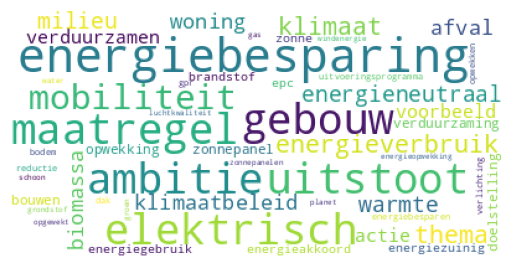

In [30]:
all_docs_matrix, all_docs_idf = tfidf_vectorize(ALL_corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)
dv_docs_matrix, dv_docs_idf = tfidf_vectorize(DV_corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

unique_for_DV = (dv_docs_matrix.mean() - all_docs_matrix.mean()).dropna().sort_values()
print(unique_for_DV.nlargest(20))

cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(unique_for_DV)
plt.axis('off')
plt.imshow(cloud);
